<img src='autoencoder.PNG' />

In [1]:
import tensorflow.keras as keras
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

In [2]:
digits = pd.read_csv('../data/digit_recognizer_train.csv')
X = digits.iloc[:, 1:]
y = digits.iloc[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_train = X_train.astype(np.float64)
X_test = X_test.astype(np.float64)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [3]:
input_nodes = X_train.shape[1]
decode_nodes = 64

In [4]:
tf_x = tf.placeholder(name='tf_x', shape=(None, input_nodes), dtype=tf.float32)

In [5]:
with tf.variable_scope("network", tf.AUTO_REUSE):
    encode_layer = tf.layers.dense(name='encode_layer', inputs=tf_x, units=decode_nodes, activation=tf.nn.relu)
    encode_layer_dp = tf.layers.dropout(encode_layer, rate=0.5, name="encode_layer_dp")
    decode_layer = tf.layers.dense(name='decode_layer', inputs=encode_layer_dp, units=input_nodes, activation=tf.nn.relu)

W0923 07:44:18.593009  1772 deprecation.py:323] From <ipython-input-5-93fdb13895a8>:2: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0923 07:44:18.605974  1772 deprecation.py:506] From C:\Users\thisi\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0923 07:44:18.864477  1772 deprecation.py:323] From <ipython-input-5-93fdb13895a8>:3: dropout (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dropout instead.


In [6]:
with tf.variable_scope('cost', tf.AUTO_REUSE):
    cost = tf.reduce_mean(tf.square(tf_x - decode_layer))

In [7]:
with tf.variable_scope('optimization', tf.AUTO_REUSE):
    optimization = tf.train.AdamOptimizer(learning_rate=0.001)
    optimization_obj = optimization.minimize(cost, name='optimization_obj')

In [8]:
from  matplotlib.cm import  binary

def show_digit(digit):
    plt.figure(figsize=(1,1))
    digit = digit.reshape(28,28)
    plt.imshow(digit, cmap = binary,
               interpolation="nearest")
    plt.axis("off")
    plt.show()

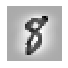

In [9]:
train_digit = X_train[:1]
show_digit(train_digit)

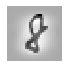

In [10]:
test_digit = X_test[:1]
show_digit(test_digit)

Train Cost :  0.4724358


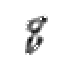

Test Cost :  2.806325


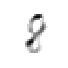

Train Cost :  0.4424788


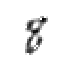

Test Cost :  2.783121


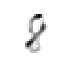

Train Cost :  0.43110323


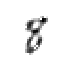

Test Cost :  2.7819576


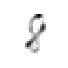

Train Cost :  0.42455673


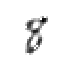

Test Cost :  2.7908132


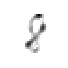

Train Cost :  0.41935557


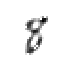

Test Cost :  2.7933092


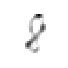

Train Cost :  0.4165912


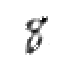

Test Cost :  2.7952967


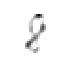

In [11]:
init_g = tf.global_variables_initializer()

epochs = 30

num_batches = 100
x_train_batches = np.array_split(X_train, indices_or_sections=num_batches)
y_train_batches = np.array_split(y_train, indices_or_sections=num_batches)

with tf.Session() as sess:
    
    sess.run(init_g)
    
    for epoch in range(epochs):
        for batch_index in range(num_batches):
            sess.run(optimization_obj, feed_dict={tf_x:x_train_batches[batch_index]})
            
        
        if ((epoch+1) % 5 == 0):
            print("Train Cost : ", sess.run(cost, feed_dict={tf_x:X_train}))
            train_decode = sess.run(decode_layer, feed_dict={tf_x:X_train})
            show_digit(train_decode[:1])
        
        if ((epoch+1) % 5 == 0):
            print("Test Cost : ", sess.run(cost, feed_dict={tf_x:X_test}))
            test_decode = sess.run(decode_layer, feed_dict={tf_x:X_test})
            show_digit(test_decode[:1])

## Deep auto encoders

In [12]:
shrinkage = 0.006
l2 = tf.keras.regularizers.l2(l=shrinkage)

with tf.variable_scope("deep_auto_network", tf.AUTO_REUSE):
    encode_layer_1 = tf.layers.dense(name='encode_layer_1', inputs=tf_x, units=300, activation=tf.nn.relu, kernel_regularizer=l2)
    encode_layer_2 = tf.layers.dense(name='encode_layer_2', inputs=encode_layer_1, units=150, activation=tf.nn.relu, kernel_regularizer=l2)
    decode_layer_1 = tf.layers.dense(name='decode_layer_1', inputs=encode_layer_2, units=150, activation=tf.nn.relu, kernel_regularizer=l2)
    decode_layer_2 = tf.layers.dense(name='decode_layer_2', inputs=decode_layer_1, units=300, activation=tf.nn.relu, kernel_regularizer=l2)
    decoder = tf.layers.dense(name='decoder', inputs=decode_layer_2, units=784, activation=tf.nn.relu, kernel_regularizer=l2)

In [13]:
with tf.variable_scope('deep_auto_cost', tf.AUTO_REUSE):
    l2_reg_loss = tf.losses.get_regularization_loss()
    cost = tf.reduce_mean(tf.square(tf_x - decoder)) +  shrinkage * l2_reg_loss

In [14]:
with tf.variable_scope('deep_auto_optimization', tf.AUTO_REUSE):
    optimization = tf.train.AdamOptimizer(learning_rate=0.001)
    optimization_obj = optimization.minimize(cost, name='optimization_obj')

In [ ]:
init_g = tf.global_variables_initializer()

epochs = 1000

num_batches = 100
x_train_batches = np.array_split(X_train, indices_or_sections=num_batches)
y_train_batches = np.array_split(y_train, indices_or_sections=num_batches)

with tf.Session() as sess:
    
    sess.run(init_g)
    
    for epoch in range(epochs):
        for batch_index in range(num_batches):
            sess.run(optimization_obj, feed_dict={tf_x:x_train_batches[batch_index]})
            #if(epoch%5 == 0 and batch_index%25 == 0):
            #    print("l2 loss : ", sess.run(l2_reg_loss, feed_dict={tf_x:x_train_batches[batch_index]}))
            
        
        if ((epoch+1) % 100 == 0):
            print("Train Cost : ", sess.run(cost, feed_dict={tf_x:X_train}))
            
            train_decode = sess.run(decoder, feed_dict={tf_x:X_train})
            show_digit(train_decode[:1])
        
        if ((epoch+1) % 100 == 0):
            print("Test Cost : ", sess.run(cost, feed_dict={tf_x:X_test}))
            test_decode = sess.run(decoder, feed_dict={tf_x:X_test})
            show_digit(test_decode[:1])

https://blog.keras.io/building-autoencoders-in-keras.html


http://ufldl.stanford.edu/tutorial/unsupervised/Autoencoders/


**Adversarial Machine Learning (GAN) - with Ian Goodfellow :** https://www.youtube.com/watch?v=3-qazNQS2JU

https://github.com/TannerGilbert/Tutorials/tree/master/Keras-Tutorials/7.%20Autoencoder